In [ ]:
# https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb

In [9]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

In [2]:
train = pd.read_csv('_RawData/train.csv')
test = pd.read_csv('_RawData/test.csv')
subm = pd.read_csv('_RawData/sample_submission.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [4]:
train['comment_text'][0]

"Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated."

In [5]:
train['comment_text'][2]

'"\n\n ""Points of interest"" \n\nI removed the ""points of interest"" section you added because it seemed kind of spammy. I know you probably didn\'t mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That\'s just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage.   "'

In [6]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.34186393464859, 595.10207169971216, 5000)

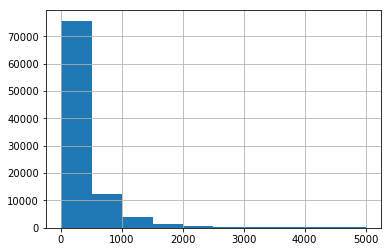

In [10]:
lens.hist()

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,9.585100e+04,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000
mean,4.994359e+11,0.096368,0.010068,0.053301,0.003182,0.049713,0.008492,0.897862
std,2.890136e+11,0.295097,0.099832,0.224635,0.056320,0.217352,0.091762,0.302831
min,2.225664e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473437e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.001297e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.501088e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999882e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
len(train),len(test)

(95851, 226998)

In [13]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [19]:
import re, string
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
re_tok = re.compile('([' + string.punctuation + '“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [20]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [21]:
trn_term_doc, test_term_doc

(<95851x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 10463449 stored elements in Compressed Sparse Row format>,
 <226998x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 26144415 stored elements in Compressed Sparse Row format>)

In [22]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [23]:
x = trn_term_doc
test_x = test_term_doc

In [24]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [25]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [27]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('Baseline - submission.csv', index=False)